# Pregnancy Risk Model:

**Задача: создать прогностическую модель рисков беременных.**

**Выбор метрики:**
- Максимизируя recall для high risk, можно добиться полного предсказания опасных случаев, однако повышаются шансы предсказать высокий риск, там где его нет на самом деле. Это может вызвать излишнее беспокойство у пациента и негативно повлияет на течение беременности.
- С другой стороны, максимизация precision позволит избежать ложных тревог, но есть риски пропустить действительно опасный случай.
- Поэтому в качестве основной метрики будем рассматривать **f1-score**, как оптимальный баланс между precision и recall.

In [ ]:
!pip install pyhumps -q
!pip install ydata_profiling -q
!pip install phik -q
!pip install catboost -q
!pip install shap -q
!pip install optuna -q

In [ ]:
import warnings
from io import StringIO

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    cross_val_score,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    RobustScaler,
    StandardScaler,
)

import lightgbm as lgb
import logging
import optuna
import shap
import phik
from ydata_profiling import ProfileReport

import humps
import joblib
import requests
import sklearn.datasets

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

In [ ]:
RANDOM_STATE = 42

In [ ]:
file_id = '1--FeiK0Yo4GARky8s3OjujnXgOeicO1V'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
df = pd.read_csv(url)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [ ]:
# преобразование названий столбцов в snake_case
df = df.copy()
df.columns = [humps.decamelize(col) for col in df.columns]

In [ ]:
df.head()

,age,systolic_bp,diastolic_bp,BS,body_temp,heart_rate,risk_level
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


## EDA

In [ ]:
report = ProfileReport(
        df, minimal=True, plot={"dpi": 200, "image_format": "png"}
    )

report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 90.87it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# баланс таргета
bar_target = px.pie(
        df,
        names='risk_level',
        color_discrete_sequence=px.colors.qualitative.Dark24,
        title='<b>Уровень интенсивности риска во время беременности</b>'
    )
bar_target.update_layout(
    height=600,
    width=600)

bar_target.update_traces(
    textinfo='percent+label',
    textposition='outside',
    insidetextfont=dict(size=14),
    pull=[0.1, 0]
)
bar_target.show()

### Обзор данных:
- Данные без пропусков.
- Типы данных соответствуют описанию.
- `age` - возраст от 10 до 70 лет, что биологически возможно (выбросов нет).
Средний возраст 29.87 лет.
- `systolic_bp` - верхнее значение артериального давления от 70 до 160 мм. рт. ст., что в допустимых пределах. Среднее 113 мм. рт. ст.
- `diastolic_bp` - нижнее значение артериального давления от 49 до 100 мм. рт. ст., что в допустимых пределах. Среднее значение 76.5 мм. рт. ст.
- `BS` - уровень глюкозы в крови. Выбросов нет, однако есть значения более 8 ммоль/л, что находится в зоне риска.
- `body_temp` - температура тела (°F). Выбросов нет. Есть значения выше 101°F (38.3°C) - есть повышенная вероятность рисков.
- `heart_rate` - нормальный пульс в покое. Есть значение 7 ударов в минуту - выброс (0.2%). Остальные значения в пределах нормы.
- `risk_level` - предсказанный уровень интенсивности риска во время беременности на основе предыдущих признаков. Сильного дисбаланса классов нет.

In [ ]:
# удалим выброс в heart_rate
df = df.loc[df['heart_rate'] > 40]

### Распределения признаков

In [ ]:
def show_title(title, x_label, y_label, ax=None, rot=False, file_name=None):
    '''
    Функция добавляет заголовок, подписи осей, вращение подписей осей.
    '''

    # задаем название графика, названия осей
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    # поворот названий осей
    if rot:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    # сохраним картинку
    if file_name:
        plt.savefig(file_name)

In [ ]:
# выделим количественные и категориальные фичи
data = df.drop(['risk_level'], axis=1)
num_column_list = data.columns[data.nunique() >= 20].tolist()
cat_column_list = data.columns[data.nunique() < 20].tolist()
num_column_list, cat_column_list

(['age', 'BS'], ['systolic_bp', 'diastolic_bp', 'body_temp', 'heart_rate'])

In [ ]:
fig = px.scatter(df, x='age', y='BS', color='risk_level', size='BS')
fig.update_layout(width=1000,
                  height=600,
                  title='Диаграмма рассеяния возраст/уровень глюкозы')
fig.show()

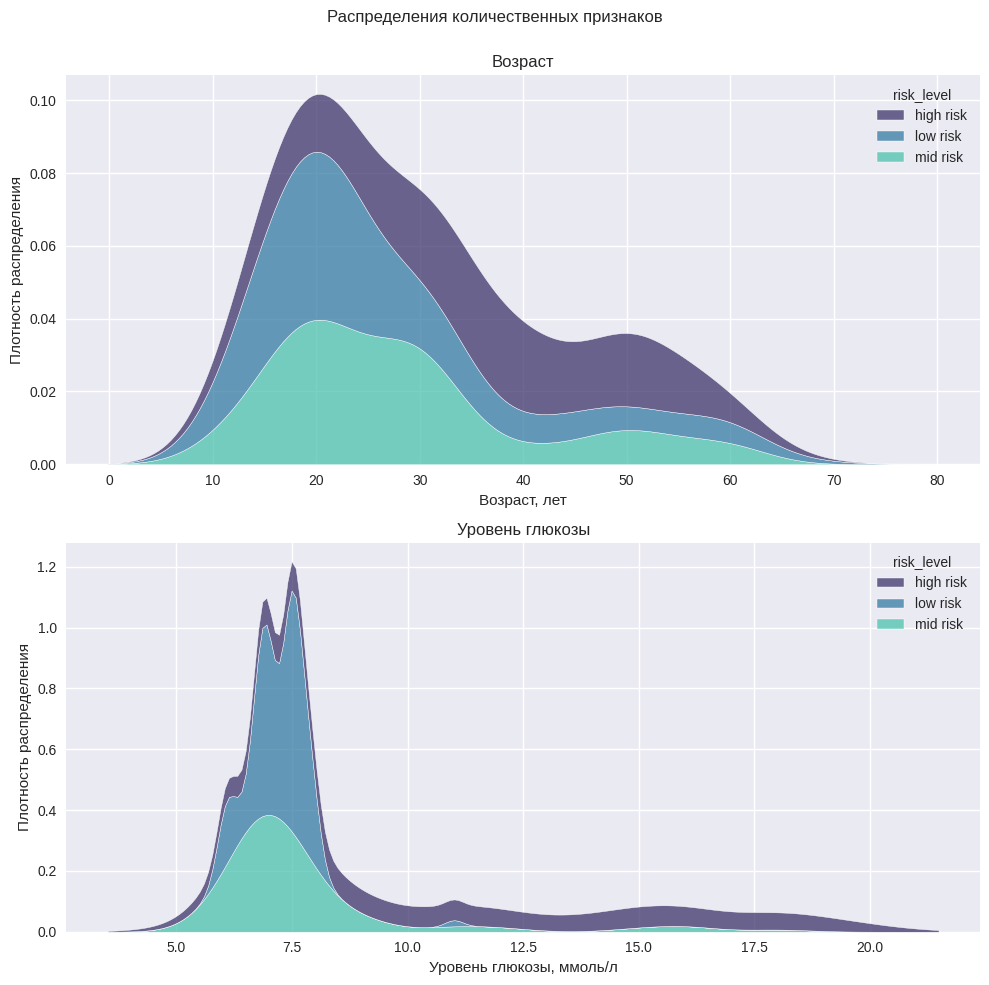

In [ ]:
title = [['Возраст', 'Возраст, лет'],
         ['Уровень глюкозы', 'Уровень глюкозы, ммоль/л']
        ]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axes = axes.flatten()

# строим графики
for ax, col, title in zip(axes, num_column_list, title):
    sns.kdeplot(data=df,
                    x=col,
                    palette='mako',
                    hue='risk_level',
                    multiple='stack',
                    common_norm=False,
                    ax=ax
                    )
    # подписи графиков
    show_title(title=title[0],
               x_label=title[1],
               y_label='Плотность распределения',
               ax=ax)

fig.suptitle('Распределения количественных признаков')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [ ]:
for col in cat_column_list:
    fig = px.violin(df, x='risk_level', y=col, box=True, points='outliers')
    fig.update_traces(box=dict(visible=True, line=dict(color='red', width=2)))
    fig.update_layout(
        width=800,
        height=600,
        title=f'Violin plot: {col} по уровням риска'
    )
    fig.show()

### Вывод по EDA

- График распределения возраста в разрезе уровня рисков показывает, что у женщин старше 40 лет рисков больше, чем у более молодых.
- График распределения глюкозы показывает повышение рисков при уровне более 8 ммоль/л. Распределения в районе 5 - 8 для малого и большого риска выглядят одинаково - тут на риски влияют другие показатели.
- Диаграмма рассеяния возраст/уровень глюкозы покаазывает, что с высоким уровнем глюкозы больше подвержены рискам.
- Violin plot: diastolic_bp по уровням риска - у женщин с повышенным давлением риск в среднем выше. high_risk - 130, mid_risk и low_risk - 120.
- Violin plot: systolic_bp по уровням риска - у женщин с повышенным давлением так же риск в среднем выше.
- Violin plot: body_temp по уровням риска - у женщин с повышенной температурой похожие шансы на средний и высокий уровень риска.
- Violin plot: heart_rate по уровням риска - у женщин с учащенным пульсом так же повышаются риски.

### Портрет беременной женщины в разрезе уровня рисков для беременности

In [ ]:
df_cols = df.drop('risk_level', axis=1).columns.tolist()

summary = pd.pivot_table(df,
               values=df_cols,
               columns='risk_level',
               aggfunc='mean')

print("--- Портрет беременной женщины ---")
summary

--- Портрет беременной женщины ---


risk_level,high risk,low risk,mid risk
BS,12.122610,7.216906,7.795744
age,36.216912,26.923267,28.363095
body_temp,98.899265,98.370792,98.833333
diastolic_bp,85.073529,72.522277,74.232143
heart_rate,76.742647,73.096535,74.175595
systolic_bp,124.194853,105.797030,113.154762


Повышенные риски:
- Имеет женщина в среднем на 10 лет старше, чем женщина с низким риском.
- Она имеет повышенный на 5 уровень глюкозы.
- Повышенной давление.
- Учащенный пульс

## Новые признаки
Основываясь на EDA, можно сконструировать новые признаки:
- `age_group` - возростная группа: 'young' - от 10 до 18 лет, 'mid' - от 18 до 35 лет, 'old' - после 35 лет.
- `body_pressure` - давление. Разность `systolic_bp` и `diastolic_bp`.

In [ ]:
df_new = df.copy()

In [ ]:
df_new['age_group'] = df_new.apply(lambda x: 'young' if x['age']<18
                                   else 'mid' if 18<=x['age'] and x['age']<35
                                   else 'old', axis=1)

In [ ]:
df_new['body_pessure'] = df_new['systolic_bp'] - df_new['diastolic_bp']

In [ ]:
df_new.head()

,age,systolic_bp,diastolic_bp,BS,body_temp,heart_rate,risk_level,age_group,body_pessure
0,25,130,80,15.0,98.0,86,high risk,mid,50
1,35,140,90,13.0,98.0,70,high risk,old,50
2,29,90,70,8.0,100.0,80,high risk,mid,20
3,30,140,85,7.0,98.0,70,high risk,mid,55
4,35,120,60,6.1,98.0,76,low risk,old,60


## Корреляционный анализ

In [ ]:
def plot_corr_matr(corr_matrix):
    """
    Отображает тепловую карту матрицы корреляции.

    Args:
        corr_matrix (pd.DataFrame): корреляционная матрица.
    """

    plt.figure(figsize=(11, 9))
    ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={'size': 8})
    plt.title('Phi_K Correlation Matrix')


    row_idx = list(corr_matrix.index).index('risk_level')
    rect = plt.Rectangle((0, row_idx), len(corr_matrix.columns), 1,
                            fill=False, edgecolor='black', linewidth=3)
    ax.add_patch(rect)

    plt.show()

In [ ]:
# выберем количественные признаки
interval_cols = (df.select_dtypes(exclude='object')
                 .columns.tolist())
interval_cols

['age', 'systolic_bp', 'diastolic_bp', 'BS', 'body_temp', 'heart_rate']

In [ ]:
corr_matrix = (df_new.phik_matrix(interval_cols=interval_cols))

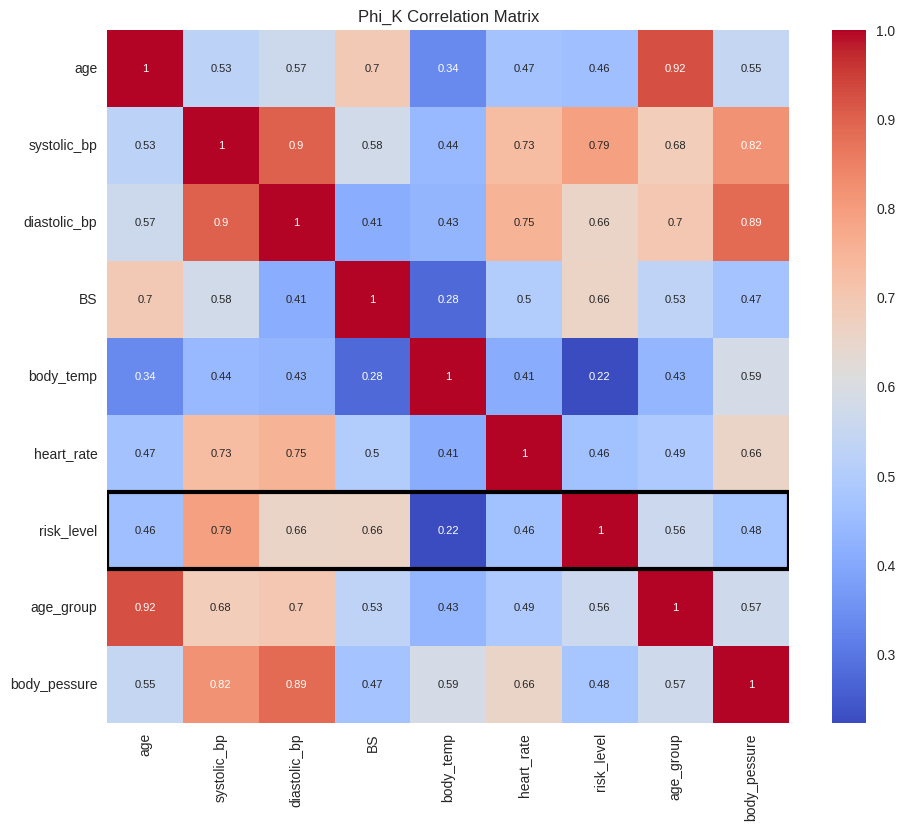

In [ ]:
plot_corr_matr(corr_matrix)

- `age` и `age_group` - показывают достаточно высокую корреляцию, однако такое разбиение на группы может быть полезно для "деревянных" моделей.

## Моделирование

In [ ]:
# Категориальные признаки для бустинга
cat_features = (df_new.drop('risk_level', axis=1)
                .select_dtypes(include=['object'])
                .columns.tolist())
df_new[cat_features] = df_new[cat_features].astype('category')

In [ ]:
def make_pipeline(df, target):
    """
    Создаёт sklearn-пайплайн для обработки данных и обучения модели.

    Args:
        df (pd.DataFrame): Исходный DataFrame с признаками и целевой переменной.
        target (str): Название колонки, содержащей целевую переменную.

    Returns:
        tuple: Кортеж из четырёх элементов:
            - pipeline (sklearn.pipeline.Pipeline): Объект обучающего пайплайна.
            - X_train (pd.DataFrame): Признаки обучающей выборки.
            - y_train (pd.Series): таргет обучающей выборки.
            - X_test (pd.DataFrame): Признаки тестовой выборки.
            - y_test (pd.Series): таргет тестовой выборки.
            - preprocessor (sklearn.compose.ColumnTransformer):
            Препроцессор признаков.
    """

    X = df.drop(target, axis=1)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
    )

    # кодируем таргет
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    # выделяем признаки для кодирования
    cat_columns = X_train.select_dtypes(include=['category']).columns.tolist()
    num_columns = (X_train
                   .select_dtypes(include=['float64', 'int64', 'int32'])
                   .columns.tolist())

    # для категориальный признаков
    cat_pipe = Pipeline(
        [('SimpleImputer', SimpleImputer(strategy='most_frequent')),
         ('ohe', OneHotEncoder(drop='first',
                               handle_unknown='ignore',
                               sparse_output=False))
        ]
    )

    # для количественных признаков
    num_pipe = Pipeline(
        [('imputer', SimpleImputer(strategy='mean')),
        ('num', MinMaxScaler())
        ]
    )

    # для обработки всех признаков
    preprocessor = ColumnTransformer(
        [('ohe', cat_pipe, cat_columns),
        ('num', num_pipe, num_columns)
        ],
        remainder='passthrough'
    )

    # финальный пайплайн
    pipe_final = Pipeline([
        ('preprocessor', preprocessor),
        ('models', LogisticRegression())
    ])

    return pipe_final, X_train, y_train, X_test, y_test, preprocessor

### Baseline
- За baseline модель возьмем LogisticRegression.

In [ ]:
param_grid_base = [
    {
        'models': [LogisticRegression(
                    solver='saga',
                    random_state=RANDOM_STATE
        )],
        'models__C': np.logspace(-3, 4, 10),
        'models__penalty': ['l2', 'l1'],
        'models__class_weight': [None, 'balanced', {0: 1, 1: 2}],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
]

In [ ]:
(pipe_final,
 X_train,
 y_train,
 X_test,
 y_test,
 preprocessor) = make_pipeline(df_new, 'risk_level')

In [ ]:
def search_model(X_train, y_train, pipe_final, param_grid, n_iter):
    """
    Функция для подбора гиперпараметров модели
    """

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

    search = RandomizedSearchCV(
        estimator=pipe_final,
        param_distributions=param_grid,
        cv=skf,
        scoring='f1_weighted',
        n_jobs=-1,
        n_iter=n_iter,
        verbose=3,
        random_state=RANDOM_STATE
    )

    return search.fit(X_train, y_train)

In [ ]:
search_base = search_model(X_train,
                           y_train,
                           pipe_final,
                           param_grid_base,
                           n_iter=100)
search_base

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['age_grou...
                                         'models__C': array([1.00000000e-03, 5.99484250e-03, 3.59381366e-02, 2.15443469e-01,
       1.29154967e+00, 7.74263683e+00, 4.64158883e+01, 2.78255940e+02,
       1.66810054e+03, 1.00000000e+04]),
                                         'models__class_weight': [None,
                                                                  'balanced',
                                                                  {0: 1, 1: 2}],
                                         'models__penalty': ['l2', 'l1'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()]}],
                   random_state=42, scoring='f1_weighted', verbose=3)

In [ ]:
def best_results_table(search):
    """
    Функция выводит датафрейм с лучшей метрикой на кросс-валидации
    """
    result = pd.DataFrame(search.cv_results_)

    result['model_name'] = (result['param_models']
                            .apply(lambda x: x.__class__.__name__))

    best_results = result[
        ['model_name', 'mean_test_score']
    ].groupby('model_name').agg('max').sort_values('mean_test_score',
                                                   ascending=False)

    best_results = best_results.rename(columns={
        'mean_test_score': 'f1_score'
    })

    print(f"f1_score на кросс-валидации:")
    return best_results.abs()

In [ ]:
best_results_base = best_results_table(search_base)
best_results_base

f1_score на кросс-валидации:


,f1_score
model_name,
LogisticRegression,0.647706


### LightGBM

In [ ]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
logging.getLogger('sklearn').setLevel(logging.WARNING)


In [ ]:
def objective(trial, X_train, y_train):

  param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 3,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": RANDOM_STATE,

        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
  }

  gbm = lgb.LGBMClassifier(**param)
  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
  scores = cross_val_score(gbm,
                           X_train,
                           y_train,
                           cv=cv,
                           scoring='f1_weighted',
                           verbose=0,
                           n_jobs=1)
  return scores.mean()

In [ ]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(
                            seed=RANDOM_STATE,
                            n_startup_trials=20
                            ),
                            pruner=optuna.pruners.HyperbandPruner(
                                min_resource=1, reduction_factor=3
                            ))
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=200, show_progress_bar=True)


  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
print("Завершено trials: {}".format(len(study.trials)))

print("Лучший trial:")
trial = study.best_trial

print("  F1: {}".format(trial.value))

print("  параметры модели: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Завершено trials: 200
Лучший trial:
  F1: 0.802710638997637
  параметры модели: 
    lambda_l1: 0.158900565128448
    lambda_l2: 0.0011814940718572107
    num_leaves: 162
    feature_fraction: 0.6079600282590392
    bagging_fraction: 0.8589844455267426
    bagging_freq: 3
    min_child_samples: 10
    learning_rate: 0.16178164298225411
    max_depth: 10
    min_child_weight: 0.0011518382898864851


In [ ]:
# лучшие параметры модели
best_params = study.best_params

final_params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 3,
    "class_weight": "balanced",
    "verbosity": -1,
    "boosting_type": "gbdt",
    **best_params
}

final_model = lgb.LGBMClassifier(**final_params)
final_model.fit(X_train, y_train)

joblib.dump(final_model, 'best_lgb_model.joblib')

print(f"Лучшая F1-score: {study.best_value:.4f}")
print("Лучшие параметры:", best_params)

Лучшая F1-score: 0.8027
Лучшие параметры: {'lambda_l1': 0.158900565128448, 'lambda_l2': 0.0011814940718572107, 'num_leaves': 162, 'feature_fraction': 0.6079600282590392, 'bagging_fraction': 0.8589844455267426, 'bagging_freq': 3, 'min_child_samples': 10, 'learning_rate': 0.16178164298225411, 'max_depth': 10, 'min_child_weight': 0.0011518382898864851}


In [ ]:
print('Прирост относительно baseline модели на кроссвалидации:')
print(f"{(study.best_value - best_results_base.iloc[0, 0]):.03}")

Прирост относительно baseline модели на кроссвалидации:
0.155


- Посчитаем f1 на тестовой выборке.

In [ ]:
final_pred = final_model.predict(X_test)
f1 = f1_score(y_test, final_pred, average='weighted')
print(f'F1 на тестовой выборке: {f1:.03}')

F1 на тестовой выборке: 0.859


## Анализ влияния признаков SHAP

In [ ]:
def shap_plot(shap_values, X_test):

    """
    Функция строит SHAP и добавляет подписи осей
    """
    class_names = ['high risk', 'low risk', 'mid risk']

    for i in range(3):

        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values[:, :, i], X_test, show=False)

        fig, ax = plt.gcf(), plt.gca()

        ax.tick_params(labelsize=12)
        ax.set_xlabel("SHAP значение (влияние на предсказание)", fontsize=10)
        ax.set_ylabel("Признаки", fontsize=10)
        ax.set_title(f"Влияние признаков на предсказания {class_names[i]}",
                     fontsize=13, pad=20)

        cb_ax = fig.axes[1]

        cb_ax.tick_params(labelsize=10)
        cb_ax.set_ylabel("Значение признака", fontsize=10)

        plt.show()

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_train)

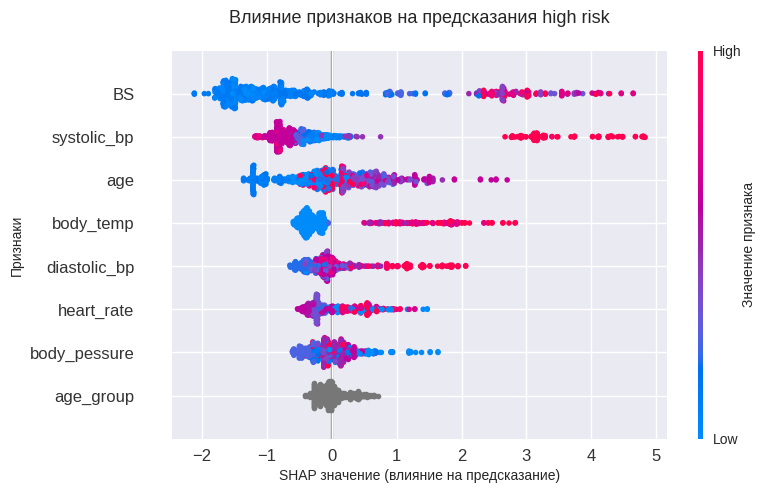

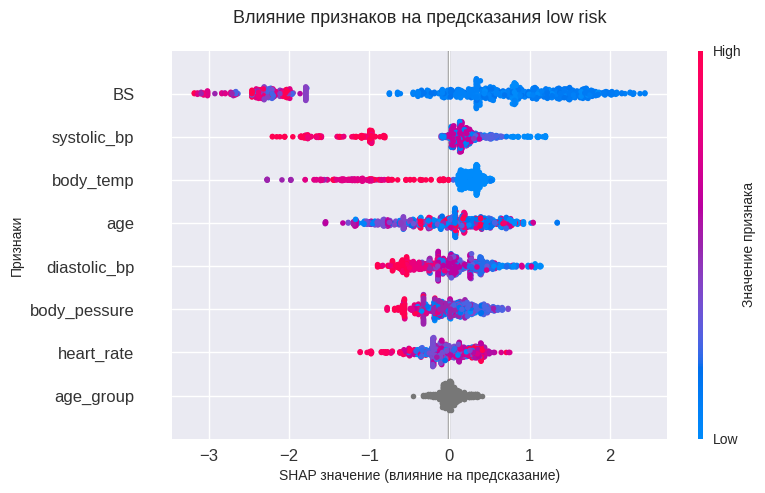

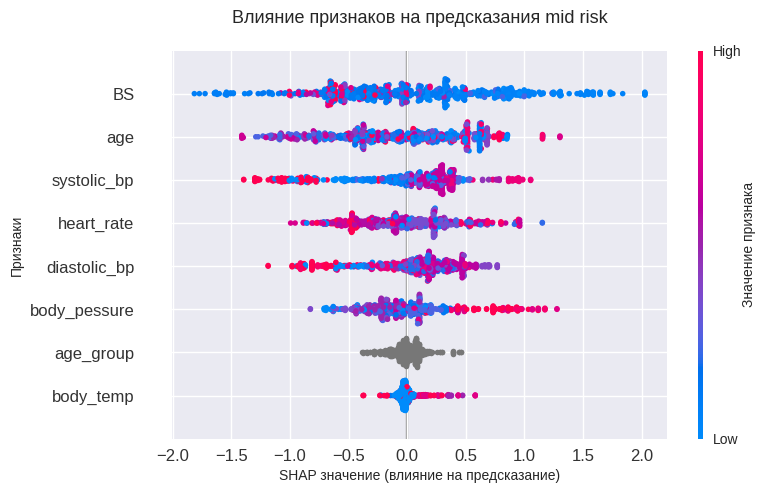

In [ ]:
shap_plot(shap_values, X_train)

### Влияние признаков
- По графикам видно, что наибольший вклад в предсказание вносят `BS, systolic_bp, age, body_temp, heart_rate`
- Чем выше `BS` тем выше риск, соответственно для низкого риска наоборот. Что согласуется с выводами EDA.
- Аналогичная картина с `systolic_bp`. Возраст так же влияет на риски, но менее значительно.
- Введенный признак `age_group` не оказывает существенного влияния на предсказания. В дальнейшей работе его можно будет исключить.

## Матрица ошибок

In [ ]:
def confusion_matrix_plot(y_true, y_pred, title=None):
  class_names = ['high risk', 'low risk', 'mid risk']
  sns.heatmap(confusion_matrix(y_true, y_pred, normalize='true'),
              annot=True,
              cmap='Greens',
              annot_kws={'fontsize': 14},
              xticklabels=class_names,
              yticklabels=class_names)

  plt.ylabel('Истинные значения')
  plt.xlabel('Предсказанные значения')
  plt.title(f'Матрица ошибок на {title}', pad=15)
  plt.show()

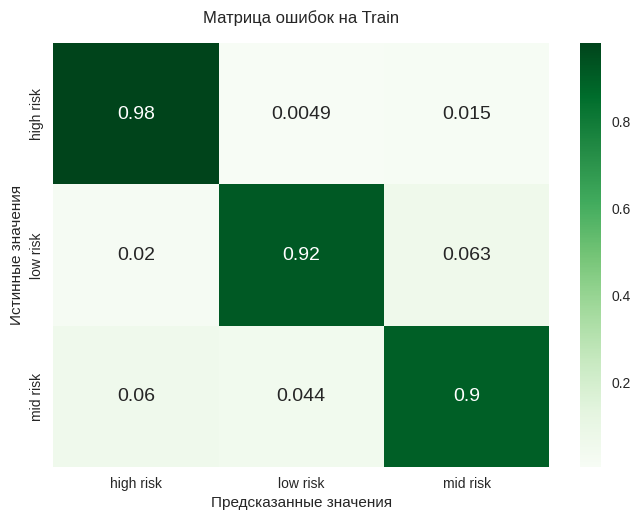

In [ ]:
train_pred = final_model.predict(X_train)
confusion_matrix_plot(y_train, train_pred, title='Train')

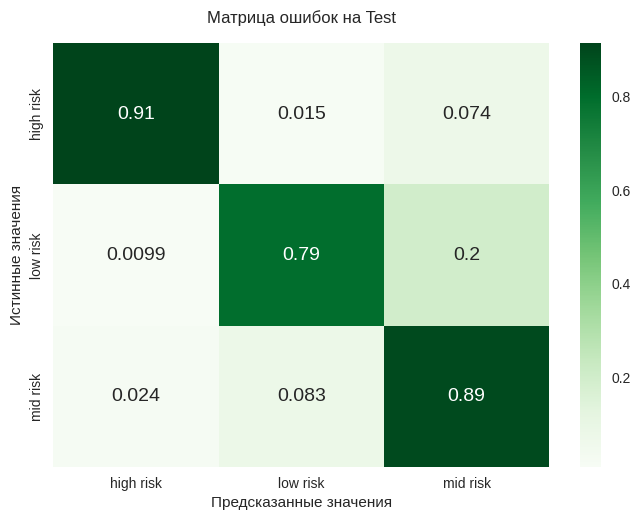

In [ ]:
confusion_matrix_plot(y_test, final_pred, title='Test')

### Общая оценка модели:
**Сильные стороны:**

- Высокая точность для high risk (91%) - критически важный класс

- Хорошее определение mid risk (89%)

- Минимальные опасные недооценки (всего 1.5% для предсказания высокого риска как низкого)

**Области для улучшения:**

- Low risk класс показывает самую низкую точность (79%)

- Значительная переоценка low risk случаев (20% определены как mid risk)

- Модель склонна к перестраховке для низкорисковых пациентов

## Вывод

### 1. EDA:
**Выявлены закономерности:**
- График распределения возраста в разрезе уровня рисков показывает, что у женщин старше 40 лет рисков больше, чем у более молодых.
- График распределения глюкозы показывает повышение рисков при уровне более 8 ммоль/л. Распределения в районе 5 - 8 для малого и большого риска выглядят одинаково - тут на риски влияют другие показатели.
- Диаграмма рассеяния возраст/уровень глюкозы покаазывает, что с высоким уровнем глюкозы больше подвержены рискам.
- Violin plot: diastolic_bp по уровням риска - у женщин с повышенным давлением риск в среднем выше. high_risk - 130, mid_risk и low_risk - 120.
- Violin plot: systolic_bp по уровням риска - у женщин с повышенным давлением так же риск в среднем выше.
- Violin plot: body_temp по уровням риска - у женщин с повышенной температурой похожие шансы на средний и высокий уровень риска.
- Violin plot: heart_rate по уровням риска - у женщин с учащенным пульсом так же повышаются риски.

**Составлен портрет пациента с высокими рисками:**   
  - Имеет женщина в среднем на 10 лет старше, чем женщина с низким риском.
  - Она имеет повышенный на 5 уровень глюкозы.
  - Повышенное давление.
  - Учащенный пульс



### 2. Новые признаки:
- `age_group` - возростная группа: 'young' - от 10 до 18 лет, 'mid' - от 18 до 35 лет, 'old' - после 35 лет.
- `body_pressure` - давление. Разность `systolic_bp` и `diastolic_bp`.




### 3. Проведен корреляционный анализ.

### 4. Модели:
- Baseline модель LogisticRegression. F1-score на кросс-валидации:

In [ ]:
best_results_base

,f1_score
model_name,
LogisticRegression,0.647706


- **LightGBM:**

In [ ]:
print(f"F1 на кросс-валидации: {(study.best_value):.03}")

F1 на кросс-валидации: 0.803


In [ ]:
print(f'F1 на тестовой выборке: {f1:.03}')

F1 на тестовой выборке: 0.859


### 5. Влияние признаков:
- По графикам видно, что наибольший вклад в предсказание вносят `BS, systolic_bp, age, body_temp, heart_rate`
- Чем выше `BS` тем выше риск, соответственно для низкого риска наоборот. Что согласуется с выводами EDA.
- Аналогичная картина с `systolic_bp`. Возраст так же влияет на риски, но менее значительно.
- Введенный признак `age_group` не оказывает существенного влияния на предсказания. В дальнейшей работе его можно будет исключить.

### 6. Матрицы ошибок:
**Сильные стороны:**

- Высокая точность для high risk (91%) - критически важный класс

- Хорошее определение mid risk (89%)

- Минимальные опасные недооценки (всего 1.5% для предсказания высокого риска как низкого)

**Области для улучшения:**

- Low risk класс показывает самую низкую точность (80%)

- Значительная переоценка low risk случаев (19% определены как mid risk)

- Модель склонна к перестраховке для низкорисковых пациентов

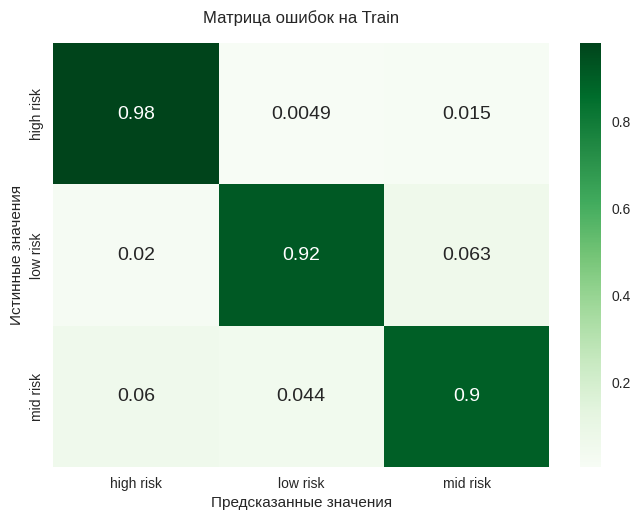

In [ ]:
confusion_matrix_plot(y_train, train_pred, title='Train')

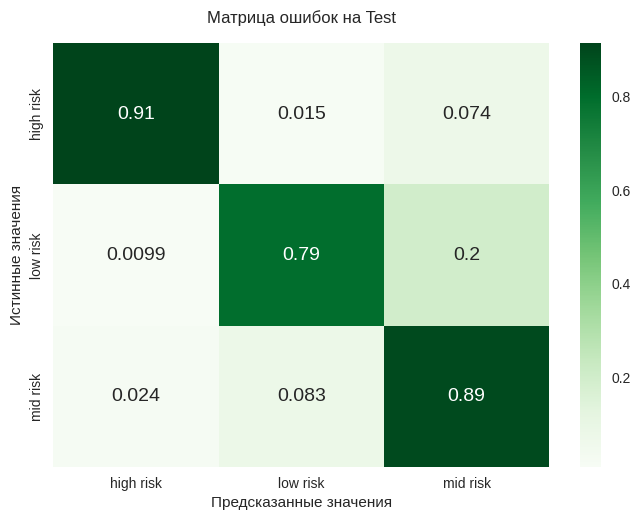

In [ ]:
confusion_matrix_plot(y_test, final_pred, title='Test')

In [ ]:
print(f"F1 на кросс-валидации: {(study.best_value):.03}")

F1 на кросс-валидации: 0.803


In [ ]:
print(f'F1 на тестовой выборке: {f1:.03}')

F1 на тестовой выборке: 0.859
